# Document Classification #

Code sample for basic document classification using scikit-learn machine learning library for Python 2

In [77]:
# core python
import io, os, random

# string management
import re

# numerical computation
import numpy as np


# data management
from pandas import DataFrame

# machine learning stuff
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# visulization
import matplotlib.pyplot as plt

# set environment
root = os.getcwd()
root = "/home/kln/Desktop/ling-evid"
os.chdir(root)

### function 1: walk directory

In [22]:
def read_dir(path, SPLITCHAR = '\n\n', NORM = False):
    """ get paragraphs from unicode documents in subdirectories of root directory on path (walk to subsub directories)
    - SPLITCHAR: escape sequences for segment (default paragraph)
    - NORM: normalization optional (remove anything but alphabetic characters and decode unicode as ascii)
    """
    paragraphs_ls, filenames_ls = [], []
    for (root, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(root,filename)
            with io.open(filepath, 'r', encoding = 'utf-8') as f:
                text = f.read()
                paragraphs = text.split(SPLITCHAR)
                del paragraphs[0]
                i = 0
                for paragraph in paragraphs:
                    paragraph = paragraph.rstrip()
                    if paragraph:
                        if NORM:
                            paragraph = re.sub(r'\W+',' ', paragraph)
                            paragraph = re.sub(r'\d','',paragraph)
                            paragraph = re.sub(r'  +',' ', paragraph)
                            # paragraph = unidecode(paragraph.lower())
                            paragraph = paragraph.lower()
                        paragraphs_ls.append(paragraph)
                        filenames_ls.append(filename+'_'+ str(i))
                        i += 1
    return filenames_ls, paragraphs_ls

### function 2: add labels to directory walk & write to dataframe

In [23]:
def make_df(path, classification):
    """ export directory walk to dataframe with CLASS INFORMATION filename as index
    """
    filenames, paragraphs = read_dir(path, NORM = True)
    rows = []
    idx = []
    i = 0
    for paragraph in paragraphs:
        rows.append({'text': paragraph, 'class': classification})
        idx.append(filenames[i])
        i += 1
    df = DataFrame(rows, index = idx)
    return df

### execute and write to .csv

In [26]:

## CLASS LABELS
NT = 'new_testament'
OT = 'old_testament'
### map CLASS to PATH
SRCS = [("DATA/KJV/OT", OT),("DATA/KJV/NT", NT)]

## Build dataframe
DATA = DataFrame({'text': [], 'class': []})
for path, classification in SRCS:
    DATA = DATA.append(make_df(path, classification))

### inspect
print DATA.shape
print DATA.head()
DATA.tail()
print DATA.text.iloc[0]

## export
DATA.to_csv("DATA/CLASS_DATA.csv")

(10317, 2)
                      class                                               text
Esther.txt_0  old_testament   now it came to pass in the days of ahasuerus ...
Esther.txt_1  old_testament   on the seventh day when the heart of the king...
Esther.txt_2  old_testament   then the king said to the wise men which knew...
Esther.txt_3  old_testament   after these things when the wrath of king aha...
Esther.txt_4  old_testament   now in shushan the palace there was a certain...
 now it came to pass in the days of ahasuerus this is ahasuerus which reigned from india even unto ethiopia over an hundred and seven and twenty provinces that in those days when the king ahasuerus sat on the throne of his kingdom which was in shushan the palace in the third year of his reign he made a feast unto all his princes and his servants the power of persia and media the nobles and princes of the provinces being before him when he shewed the riches of his glorious kingdom and the honour of his excellen

### read and check distribution of data ###

In [31]:
import pandas as pd

DATA = pd.read_csv("DATA/CLASS_DATA.csv", index_col = 0, encoding = 'utf-8')
print DATA.shape
print DATA.head()

(10317, 2)
                      class                                               text
Esther.txt_0  old_testament   now it came to pass in the days of ahasuerus ...
Esther.txt_1  old_testament   on the seventh day when the heart of the king...
Esther.txt_2  old_testament   then the king said to the wise men which knew...
Esther.txt_3  old_testament   after these things when the wrath of king aha...
Esther.txt_4  old_testament   now in shushan the palace there was a certain...


In [36]:
def printdist(DF):
    for label in set(DF['class']):
        #print label
        print "number of {}: {}".format(label,sum(DF['class'] == label))

printdist(DATA)

number of old_testament: 9461
number of new_testament: 856


In [47]:
def balance(df, n, classcol = 'class'):
    random.seed(1234)
    res = pd.DataFrame(columns = df.columns)
    C = list(set(df[classcol]))
    for c in C:
        idx = df[df[classcol] == c].index.tolist()
        df_c = df.loc[random.sample(idx,n)]
        res = res.append(df_c)
    return res.reindex(np.random.permutation(res.index))

DATA_bal = balance(DATA,800)
DATA_bal.shape 

(1600, 2)

### split data set ###

In [52]:
ratio = 0.8
mask = np.random.rand(len(DATA_bal)) <= ratio

TRAIN = DATA_bal[mask]
TEST = DATA_bal[~mask]

print TRAIN.shape
print TEST.shape

# training set
X_train = TRAIN['text'].values
y_train = TRAIN['class'].values

# test set
X_test = TEST['text'].values
y_test = TEST['class'].values

(1266, 2)
(334, 2)


Transform data to document term matrix

In [59]:
vectorizer = CountVectorizer(ngram_range = (1,2), stop_words = 'english', 
                             lowercase = True, max_df = 0.95, min_df = 0.01, 
                             max_features = 500)

FEAT_train = vectorizer.fit_transform(X_train)
FEAT_test = vectorizer.transform(X_test)
FEAT_names = vectorizer.get_feature_names()

Train naive bayes classifier

In [61]:
classifier = MultinomialNB()
classifier.fit(FEAT_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Evaluate performance

In [64]:
pred = classifier.predict(FEAT_test)
print pred[:10]

[u'old_testament' u'old_testament' u'old_testament' u'new_testament'
 u'new_testament' u'new_testament' u'old_testament' u'new_testament'
 u'new_testament' u'new_testament']


In [71]:
confmat = metrics.confusion_matrix(y_test, pred)

print "Accuracy = {}".format(round(metrics.accuracy_score(y_test, pred),2))
print
print
print metrics.classification_report(y_test, pred)

Accuracy = 0.86


               precision    recall  f1-score   support

new_testament       0.78      0.99      0.87       161
old_testament       0.98      0.74      0.84       173

  avg / total       0.89      0.86      0.86       334



ROC curve

In [87]:
y_scores = classifier.predict_proba(FEAT_test)
FPR, TPR, thresholds = metrics.roc_curve(y_test, y_scores[:,1], pos_label = 'old_testament')
AUC = round(metrics.auc(FPR,TPR), 2)

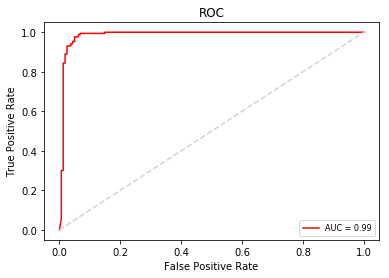

In [90]:
plt.title('ROC')
plt.plot(FPR,TPR, c = 'r', label = ('AUC = {}'.format(AUC)))
plt.legend(loc = 'lower right', prop={'size':8})
plt.plot([0,1],[0,1], c = 'lightgrey',linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.savefig('ROC.png', dpi = 300)
plt.close()